In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [114]:
# # trying to save as txt

# z = np.arange(0,5,10)
# np.savetxt('C:\\Users\\ahron\\AppData\\Local\\Temp\\Temp1_FDR-R-Code.zip\\FDR-R-Code\\testnow2.txt', z, delimiter=',')

# 0.) Data loading & Wrangling

In [115]:
%%time
df = pd.read_excel('ayp03dbf.xlsx')

Wall time: 55.1 s




Important columns (Definitions: https://www.cde.ca.gov/re/pr/reclayout03p1.asp ):

**GENERAL**

- **CDS** - County/District/School code - probably the unique identifier in the data
- **SNAME** - school name
- **TYPE** - 1=Unified, 2=Elementary District, 3=9-12 High District, 4=7-12 High District, E=Elementary School, M=Middle School, H=High School

**SCHOOLWIDE**

- **m_enr**	- Schoolwide Enrollment Math
- **m_tst** - Schoolwide Tested Math
- **m_prate** - Schoolwide Participation Rate Math
- **m_prof** - Schoolwide Math students scoring Proficient or Above
- **m_pprof** - Schoolwide Math Percent of students scoring Proficient or Above
- **m_prate** - Schoolwide Participation Rate Math

**SED**

- **MNP_SD** - 	Math students scoring Proficient or Above Socioeconomic Disadvantaged
- **MPP_SD** - Math Percent of students scoring Proficient or Above Socioeconomic Disadvantaged
- **me_sd** - Math Enrollment Socioeconomic Disadvantaged - נרשמו
- **mt_sd** - Math Tested Socioeconomic Disadvantaged - נבחנו
- **mp_sd** - Math Participation Rate Socioeconomic Disadvantaged

In [116]:
# Sanity check
(df['MT_SD'] < df['MNP_SD']).sum()

0

In [117]:
df = df.rename(columns={
                        "MT_SD": "#_sed_tested",
                        "MNP_SD": "#_sed_scored_proficient", 
                        #"MPP_SD": "perc_sed_proficient",
                        "ME_SD": "#_sed_enrolled",
                        
                        "M_ENR": "#_enrolled__school_size",
                        "M_TST": "#_tested",
                        "M_PRATE": "perc_participation",
                        "M_PROF": "#_scored_proficient",
                        "M_PPROF": "perc_proficient"})

In [118]:
df_analysis = df[['CDS', 'SNAME', 'TYPE', '#_enrolled__school_size', '#_tested', 'perc_participation', '#_scored_proficient', 'perc_proficient', '#_sed_enrolled', '#_sed_tested', '#_sed_scored_proficient']]
#df_analysis.head(2)

In [119]:
# more sed & sea calculations
df_analysis['real_perc_sed_proficient'] = (df_analysis['#_sed_scored_proficient'] / df_analysis['#_sed_tested']) #* 100

df_analysis['#_sea_tested'] = df_analysis['#_tested'] - df_analysis['#_sed_tested']
df_analysis['#_sea_scored_proficient'] = df_analysis['#_scored_proficient'] - df_analysis['#_sed_scored_proficient']
df_analysis['real_perc_sea_proficient'] = (df_analysis['#_sea_scored_proficient'] / df_analysis['#_sea_tested']) #* 100

C:\Users\ahron\AppData\Local\Temp/ipykernel_19556/1313611660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['real_perc_sed_proficient'] = (df_analysis['#_sed_scored_proficient'] / df_analysis['#_sed_tested']) #* 100
C:\Users\ahron\AppData\Local\Temp/ipykernel_19556/1313611660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['#_sea_tested'] = df_analysis['#_tested'] - df_analysis['#_sed_tested']
C:\Users\ahron\AppData\Local\Temp/ipykernel_19556/1313611660.py:5: SettingWithCopy

In [120]:
df_analysis.head(3)

,CDS,SNAME,TYPE,#_enrolled__school_size,#_tested,perc_participation,#_scored_proficient,perc_proficient,#_sed_enrolled,#_sed_tested,#_sed_scored_proficient,real_perc_sed_proficient,#_sea_tested,#_sea_scored_proficient,real_perc_sea_proficient
0,0,State Total,NaN,3916472.0,3830513.0,97.8,1486839.0,38.8,2099619.0,2056934.0,542964.0,0.263968,1773579.0,943875.0,0.532187
1,1100170000000,NaN,1,155.0,141.0,90.9,0.0,0.0,147.0,114.0,0.0,0.000000,27.0,0.0,0.000000
2,1100170130401,Juvenile Hall/Court,H,101.0,94.0,93.0,0.0,0.0,100.0,71.0,0.0,0.000000,23.0,0.0,0.000000


# 1.) Data Cleaning, filtering & clustering

- According to Rogosa(2003) & Efron:

- **Rogosa:** "under the law, if a subgroup defined by ethnicity or socioeconomic disadvantage constitutes at least 100 pupils, i.e., at least 100 pupils with valid STAR scores, that subgroup is numerically significant. (CDE Explanatory Notes). In the analyses of this section, results are presented for both SD subgroups of at least 30 students and the subset of those subgroups which are deemed "numerically significant"".

In [121]:
# How many Obs. contain nulls?

df_analysis_nonull = df_analysis.dropna()
len(df_analysis) - len(df_analysis_nonull)

2953

In [122]:
# Size of the non-null sample

len(df_analysis_nonull)

7106

In [123]:
# Out of the non-nulls (7106), How many Obs. are with less than 30 sed pupils?

len(df_analysis_nonull[df_analysis_nonull['#_sed_tested'] < 30])

567

In [124]:
# Out of the non-nulls (7106), How many Obs. are with less than 100 sed pupils?

len(df_analysis_nonull[df_analysis_nonull['#_sed_tested'] < 100])

2178

- **Cai & Sun's '09** filtering, is: 
   - Based on a preliminary cluster analysis, we divide all schools into three groups according to the number of scores reported (ni + ni): 
        - small schools (ni + ni ≤ 120) 
        - medium schools (120 < ni + ni ≤ 900) 
        - large schools (ni + ni > 900) 

The group characteristics are summarized in Table 3 (attached).
 
 

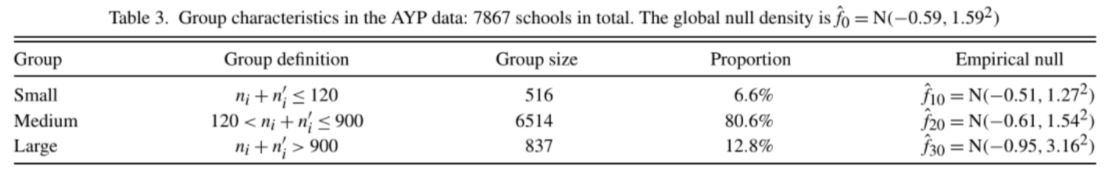

In [125]:
# Creating the clusters, according to cai & sun
df_analysis_nonull['group_size'] = np.where(df_analysis_nonull['#_enrolled__school_size'] < 901, "medium", "large")
df_analysis_nonull['group_size'] = np.where(df_analysis_nonull['#_enrolled__school_size'] < 121, "small", df_analysis_nonull['group_size'])

C:\Users\ahron\AppData\Local\Temp/ipykernel_19556/276520550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis_nonull['group_size'] = np.where(df_analysis_nonull['#_enrolled__school_size'] < 901, "medium", "large")
C:\Users\ahron\AppData\Local\Temp/ipykernel_19556/276520550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis_nonull['group_size'] = np.where(df_analysis_nonull['#_enrolled__school_size'] < 121, "small", df_analysis_nonull['group_size'])


In [126]:
df_analysis_nonull['group_size'].value_counts()

medium    5914
large      719
small      473
Name: group_size, dtype: int64

In [13]:
df_analysis_nonull['group_size'].value_counts()

medium    5914
large      719
small      473
Name: group_size, dtype: int64

# 2.) Creating Z values (& saving them)

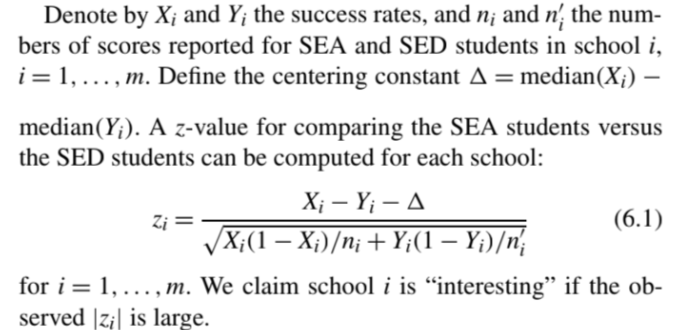

In [14]:
# ### X
# # Our "X" is the success rate of SEA
# # df_analysis_nonull['real_perc_sea_proficient']
# X = np.array(df_analysis_nonull['real_perc_sea_proficient'])

# # X's n is the number of SEA students that were TESTED
# n_X = df_analysis_nonull['#_sea_tested']


# ### Y
# # Our "Y" is the success rate of SED
# # df_analysis_nonull['real_perc_sed_proficient']
# Y = np.array(df_analysis_nonull['real_perc_sed_proficient'])

# # Y's n' is the number of SEA students that were TESTED
# n_Y = df_analysis_nonull['#_sed_tested']


# ### DELTA
# # Our "delta" is the gap between the two
# delta = np.median(np.array(df_analysis_nonull['real_perc_sea_proficient'])) - np.median(np.array(df_analysis_nonull['real_perc_sed_proficient']))


# z_vec = (X - Y - delta) / np.sqrt( ((X*(1-X))/n_X) + ((Y*(1-Y))/n_Y) )

# # It's minus 66 values (65 minus inf & 1 plus inf)
# z_vec = z_vec[~(z_vec>10000)]
# z_vec = z_vec[~(z_vec<-10000)]
# z_vec

## IMPORTANT NOTE: 
#### THROWING AWAY SCHOOLS WHERE BOTH SEA & SED CAME WITH 0 SUCCESS RATE (INF OR -INF "Z" VALUE)

In [127]:
def vec_z_creator(df, size, whole = False):
    
    if whole:
        df_ = df
    else:
        df_ = df[df['group_size'] == size]
    
    ### X
    # Our "X" is the success rate of SEA
    # df_analysis_nonull['real_perc_sea_proficient']
    X = np.array(df_['real_perc_sea_proficient'])

    # X's n is the number of SEA students that were TESTED
    n_X = df_['#_sea_tested']


    ### Y
    # Our "Y" is the success rate of SED
    # df_analysis_nonull['real_perc_sed_proficient']
    Y = np.array(df_['real_perc_sed_proficient'])

    # Y's n' is the number of SEA students that were TESTED
    n_Y = df_['#_sed_tested']


    ### DELTA
    # Our "delta" is the gap between the two
    delta = np.median(np.array(df_['real_perc_sea_proficient'])) - np.median(np.array(df_['real_perc_sed_proficient']))

    z_vec = (X - Y - delta) / np.sqrt( ((X*(1-X))/n_X) + ((Y*(1-Y))/n_Y) )
    z_vec = z_vec[~(z_vec>10000)]
    z_vec = z_vec[~(z_vec<-10000)]
    
    return z_vec

In [128]:
z_small = vec_z_creator(df_analysis_nonull, "small")
z_medium = vec_z_creator(df_analysis_nonull, "medium")
z_large = vec_z_creator(df_analysis_nonull, "large")

In [134]:
# saving these 3 Z vectors

np.savetxt('C:\\Users\\ahron\\AppData\\Local\\Temp\\Temp1_FDR-R-Code.zip\\FDR-R-Code\\z_small.txt', z_small, delimiter=',')

In [135]:
np.savetxt('C:\\Users\\ahron\\AppData\\Local\\Temp\\Temp1_FDR-R-Code.zip\\FDR-R-Code\\z_medium.txt', z_medium, delimiter=',')

In [136]:
np.savetxt('C:\\Users\\ahron\\AppData\\Local\\Temp\\Temp1_FDR-R-Code.zip\\FDR-R-Code\\z_large.txt', z_large, delimiter=',')

<AxesSubplot:>

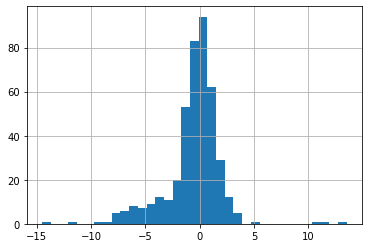

In [129]:
z_small.hist(bins=35)

<AxesSubplot:>

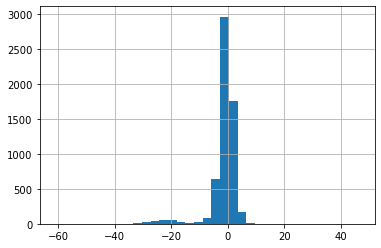

In [130]:
z_medium.hist(bins=35)

<AxesSubplot:>

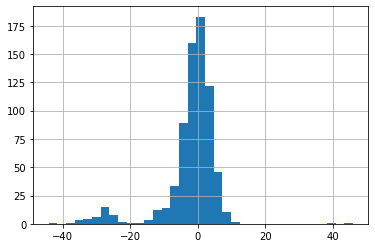

In [131]:
z_large.hist(bins=35)

# 3.)  Analyzing according to the R library - FDR-R-Code

In [20]:
import fdr_r_code as frc

In [21]:
alpha = 0.05

## 3.1.) Demo with hivdata 

In [22]:
hivdata = pd.read_csv('hivdata.txt', sep=" ", header=None)

zv_lfdr_hiv, mu_hiv, s_hiv = frc.adaptZ(np.array(hivdata[0]), alpha)
#hivdemo

In [23]:
zv_lfdr_hiv, mu_hiv, s_hiv

(array([1.07132358e+00, 1.01437641e+00, 1.20884914e-08, ...,
        1.08954695e+00, 9.99949330e-01, 1.06277046e+00]),
 -0.08059985786173429,
 0.770900397650607)

## 3.2.) Analysis for the whole data (for thesis writing puposes)

In [29]:
z_whole = vec_z_creator(df_analysis_nonull, "whole", True)

<AxesSubplot:>

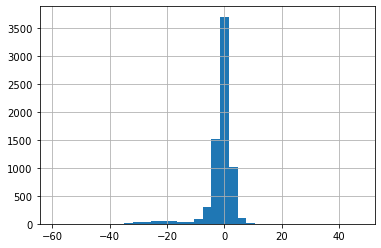

In [30]:
z_whole.hist(bins=35)

In [34]:
lfdr_whole, mu_whole, s_whole = frc.adaptZ(np.array(z_whole), alpha)

In [75]:
lfdr_whole, mu_whole, s_whole

(array([1.38826892, 1.37867242, 1.1254486 , ..., 1.37099096, 1.16350017,
        1.3953526 ]),
 -0.16880117512810905,
 1.8100680967893532)

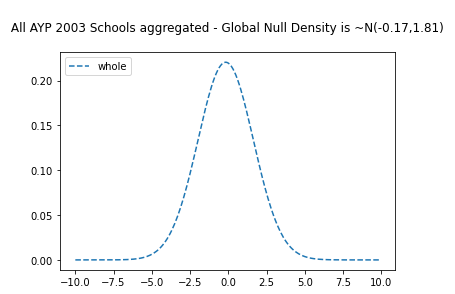

In [45]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-10, 10, 0.1)

plt.plot(x_axis, norm.pdf(x_axis, mu_whole, s_whole), "--", label="whole")
plt.title(f"\n All AYP 2003 Schools aggregated - Global Null Density is ~N({round(mu_whole,2)},{round(s_whole,2)}) \n")
plt.legend(loc="upper left")
plt.show()

## 3.3.) Analysis per school_size 

- '-'	solid line style
- '--'	dashed line style
- '-.'	dash-dot line style
- ':'	dotted line style
- '.'	point marker

In [132]:
# declaring again in this notebook

z_small = vec_z_creator(df_analysis_nonull, "small")
z_medium = vec_z_creator(df_analysis_nonull, "medium")
z_large = vec_z_creator(df_analysis_nonull, "large")

In [47]:
# locfdrs, mus, sigmas

lfdr_small, mu_small, s_small = frc.adaptZ(np.array(z_small), alpha)
lfdr_medium, mu_medium, s_medium = frc.adaptZ(np.array(z_medium), alpha)
lfdr_large, mu_large, s_large = frc.adaptZ(np.array(z_large), alpha)

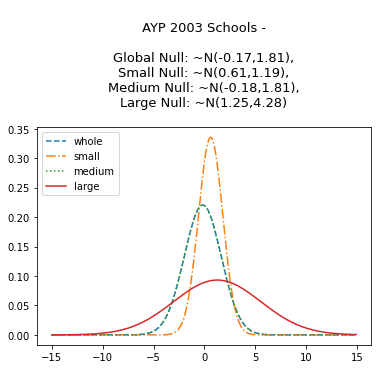

In [65]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-15, 15, 0.1)

plt.plot(x_axis, norm.pdf(x_axis, mu_whole, s_whole), "--", label="whole")
plt.plot(x_axis, norm.pdf(x_axis, mu_small, s_small), "-.", label="small")
plt.plot(x_axis, norm.pdf(x_axis, mu_medium, s_medium), ":", label="medium")
plt.plot(x_axis, norm.pdf(x_axis, mu_large, s_large ), "-", label="large")


plt.title(f"\n AYP 2003 Schools - \n\nGlobal Null: ~N({round(mu_whole,2)},{round(s_whole,2)}),\nSmall Null: ~N({round(mu_small,2)},{round(s_small,2)}),\nMedium Null: ~N({round(mu_medium,2)},{round(s_medium,2)}),\nLarge Null: ~N({round(mu_large,2)},{round(s_large,2)})\n ", fontsize=13)

plt.legend(loc="upper left")
plt.show()

In [69]:
len(z_whole), len(z_small), len(z_medium), len(z_large) 

(7040, 424, 5898, 718)

In [72]:
718/7040

0.10198863636363636

# 4.) Applying 8 procedures to it: SL, CL, 3ind, 3dep
- Missions:
    - A mapper for the locfdr CLFDR per group (dictionary probably)

In [76]:
lfdr_whole
lfdr_small
lfdr_medium
lfdr_large

array([1.98502367e+00, 2.11243179e+00, 2.10563467e+00, 2.04095565e+00,
       2.11825097e+00, 2.08841392e+00, 1.93880202e+00, 2.06909281e+00,
       2.11073785e+00, 1.48156657e+00, 2.04045241e-01, 4.08150040e-02,
       2.08504129e+00, 1.68484971e-01, 1.93362983e+00, 8.94424726e-01,
       1.88682314e+00, 1.33922111e+00, 2.04940685e+00, 1.98481576e+00,
       1.41628881e+00, 1.87227338e+00, 1.40483854e+00, 2.10910770e+00,
       2.12320049e+00, 1.94405558e+00, 1.79780816e+00, 2.11259368e+00,
       2.10665674e+00, 2.11733077e+00, 1.11390448e+00, 1.42091556e+00,
       6.09604816e-01, 1.22966366e+00, 7.06684150e-01, 1.83816518e+00,
       1.53491529e+00, 2.10370954e+00, 2.08820009e+00, 2.08476019e+00,
       2.09183810e+00, 2.07437736e+00, 2.12037955e+00, 1.64946945e+00,
       2.12183925e+00, 2.05943412e+00, 1.87898977e+00, 8.49057211e-01,
       2.11656363e+00, 1.21569363e+00, 1.86199775e+00, 2.11956590e+00,
       1.99444343e+00, 2.01626174e+00, 1.98421035e+00, 1.96364695e+00,
      

In [89]:
(np.sort(lfdr_whole) < 1).sum() / len(np.sort(lfdr_whole))

0.3495738636363636

In [90]:
(np.sort(lfdr_small) < 1).sum() / len(np.sort(lfdr_small))

0.5377358490566038

In [91]:
(np.sort(lfdr_medium) < 1).sum() / len(np.sort(lfdr_medium))

0.32383858935232285

In [92]:
(np.sort(lfdr_large) < 1).sum() / len(np.sort(lfdr_large))

0.2075208913649025

In [93]:
universal_olocfdr = [np.sort(lfdr_small), np.sort(lfdr_medium), np.sort(lfdr_large)]

In [77]:
def SLFDR_decision_rule(locfdr, alpha):
    # recieves: SORTED np.array - locfdr of some group "k"  +  alpha
    # returns: number of rejections + olocfdr of the rejected ones
    
    locfdr_cumsum = np.cumsum(locfdr)
    rule_sums = locfdr_cumsum / np.array(list(range(1, len(locfdr_cumsum)+1))) 
    
    for statistic in rule_sums[::-1]:
        if statistic <= alpha:
            break
            
    if (statistic == rule_sums[0]) & (statistic > alpha):        
        num_rejections = 0
        rejections_olocfdr = 0        
        
    else:
        num_rejections = list(rule_sums).index(statistic) + 1
        rejections_olocfdr = locfdr[:num_rejections]
        
    return num_rejections, rejections_olocfdr

In [102]:
def SLFDR_analysis(locfdr, alpha):
    
    # "locfdr" should be a LIST of SORTED locfdrs (np.arrays prefferably)
    
    R_list = []
    R_olocfdr_list = []
    
    for i in range(len(locfdr)):
        R, R_olocfdr = SLFDR_decision_rule(locfdr[i], alpha)
        R_list.append(R)
        R_olocfdr_list.append(R_olocfdr)
        
    return R_list, R_olocfdr_list

In [103]:
def CLFDR_analysis(locfdr, alpha):
    
    # "locfdr" should be a LIST of SORTED locfdrs (np.arrays prefferably)
    
    locfdr_agg_stacked = np.hstack(locfdr)
    olocfdr = np.sort(locfdr_agg_stacked)
    
    R, R_olocfdr = SLFDR_decision_rule(olocfdr, alpha)
    
    return R, R_olocfdr

In [106]:
R_SLFDR, R_OLOCFDR_SLFDR = SLFDR_analysis(universal_olocfdr, alpha)
R_CLFDR, R_OLOCFDR_CLFDR = CLFDR_analysis(universal_olocfdr, alpha)
np.sum(np.array(R_SLFDR)), R_SLFDR, R_CLFDR

(663, [81, 508, 74], 666)

## 4.1.) fdep that i think wasn't used
#### it was later developed in the 'mother simulation'

In [ ]:

def fdep_marginals_groups(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR, musMargPFDR, musMargMFDR):

    marglocfdr_agg = []
    
    #  columns order: marglocfdrFDR, marglocfdrpFDR, marglocfdrmFDR
    minprob_mat = np.zeros((1,6),float)
    lev_mat = np.zeros((1,6),float) 
    pow_mat = np.zeros((1,6),float) 
    ev_mat = np.zeros((1,6),float) 
    er_mat = np.zeros((1,6),float) 
    
    
    # RUTH AND SAHARON LOGIC IS MORE LIKE "CLFDR" - WE TAKE EVERYTHING FROM ALL THE GROUPS, AND THEN COMBINE
    for i in range(len(mu0)):
        # - - - BLOCK BETA - - - 
        block_beta = my_rbeta(num_hypo[i], 
                                prob_to_1[i], 
                                mu0[i], 
                                mu1[i], 
                                variance_0[i], 
                                variance_1[i],
                                False)

        # - - - for marginal rule - - -
        dist_0 = stats.norm(mu0[i], np.sqrt(variance_0[i]))
        dist_1 = stats.norm(mu1[i], np.sqrt(variance_1[i]))
        margprob_ = (1-prob_to_1[i]) * dist_0.pdf(block_beta)  +  prob_to_1[i] * dist_1.pdf(block_beta)
        marglocfdr = (1-prob_to_1[i]) * dist_0.pdf(block_beta) / margprob_    
        marglocfdr_agg.append(marglocfdr)
    
    marglocfdr_agg_stacked = np.hstack(marglocfdr_agg)
    omarglocfdr = np.sort(marglocfdr_agg_stacked)
    amarg = 1 - omarglocfdr
    omarglocfdr_numba = numba.typed.List(omarglocfdr)    
    bmarg = np.array(BZCpp_numba_jit(omarglocfdr_numba)) # it WAS np.array but now it's a LIST of np.arrays so that when you take an index from it, it will be fine
    
    # marglocfdrFDR -v-     
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargFDR, a=amarg, b_1=bmarg, 
                                                                               b_2=bmarg, ind=3, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr, 
                                                                               alpha = alpha)
    # marglocfdrpFDR -v-
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargPFDR, a=amarg, b_1=bmarg, 
                                                                               b_2=bmarg, ind=4, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr,  
                                                                               alpha = alpha)
    # marglocfdrmFDR 
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargMFDR, a=amarg, b_1=(omarglocfdr - alpha),
                                                                               b_2=bmarg, ind=5, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr, 
                                                                               alpha = alpha)
    return lev_mat, pow_mat, minprob_mat, ev_mat, er_mat




In [ ]:
#### PLAYING WITH R&S IND



def fdep_marginals_groups(alpha, num_hypo, prob_to_1, mu0, mu1, variance_0, variance_1, musMargFDR, musMargPFDR, musMargMFDR):

    marglocfdr_agg = []
    
    #  columns order: marglocfdrFDR, marglocfdrpFDR, marglocfdrmFDR
    minprob_mat = np.zeros((1,6),float)
    lev_mat = np.zeros((1,6),float) 
    pow_mat = np.zeros((1,6),float) 
    ev_mat = np.zeros((1,6),float) 
    er_mat = np.zeros((1,6),float) 
    
    
    
    
    
    
    
    
    
    
    # RUTH AND SAHARON LOGIC IS MORE LIKE "CLFDR" - WE TAKE EVERYTHING FROM ALL THE GROUPS, AND THEN COMBINE
    for i in range(len(mu0)):
        # - - - BLOCK BETA - - - 
        block_beta = my_rbeta(num_hypo[i], 
                                prob_to_1[i], 
                                mu0[i], 
                                mu1[i], 
                                variance_0[i], 
                                variance_1[i],
                                False)

        # - - - for marginal rule - - -
        dist_0 = stats.norm(mu0[i], np.sqrt(variance_0[i]))
        dist_1 = stats.norm(mu1[i], np.sqrt(variance_1[i]))
        margprob_ = (1-prob_to_1[i]) * dist_0.pdf(block_beta)  +  prob_to_1[i] * dist_1.pdf(block_beta)
        marglocfdr = (1-prob_to_1[i]) * dist_0.pdf(block_beta) / margprob_    
        marglocfdr_agg.append(marglocfdr)
    
    
    
    
    
    
    
    
    
    marglocfdr_agg_stacked = np.hstack(marglocfdr_agg)
    omarglocfdr = np.sort(marglocfdr_agg_stacked)
    amarg = 1 - omarglocfdr
    omarglocfdr_numba = numba.typed.List(omarglocfdr)    
    bmarg = np.array(BZCpp_numba_jit(omarglocfdr_numba)) # it WAS np.array but now it's a LIST of np.arrays so that when you take an index from it, it will be fine
    
    # marglocfdrFDR    
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargFDR, a=amarg, b_1=bmarg, 
                                                                               b_2=bmarg, ind=3, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr, 
                                                                               alpha = alpha)
    # marglocfdrpFDR 
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargPFDR, a=amarg, b_1=bmarg, 
                                                                               b_2=bmarg, ind=4, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr,  
                                                                               alpha = alpha)
    # marglocfdrmFDR 
    lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMargMFDR, a=amarg, b_1=(omarglocfdr - alpha),
                                                                               b_2=bmarg, ind=5, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat,  
                                                                               olocfdr_function=omarglocfdr, 
                                                                               alpha = alpha)
    return lev_mat, pow_mat, minprob_mat, ev_mat, er_mat




In [ ]:
 
### PLAYING WITH THE DEP


def fdep_ORACLE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha):

    # "columns order: OMTFDR, OMTpFDR, OMTmFDR ... "
    minprob_mat = np.zeros((1,3),float)
    lev_mat = np.zeros((1,3),float)
    pow_mat = np.zeros((1,3),float)
    ev_mat = np.zeros((1,3),float)
    er_mat = np.zeros((1,3),float)  
    
    # - - - for oracle rule - - -
    a, b, locFDR = AandB_a_and_b_generator (olocfdr_packed, maxiter)
    
    for iter in range(maxiter): 

        # OMTFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=0, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)      
         # OMTpFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musPFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=1, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)    
        # OMTMFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMFDR, 
                                                                               a=a[iter-1], 
                                                                               b_1=locFDR[iter] - alpha, 
                                                                               b_2=b[iter], 
                                                                               ind=2, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)                  

    return lev_mat/maxiter, pow_mat/maxiter, minprob_mat/maxiter, ev_mat/maxiter, er_mat/maxiter

    

In [ ]:

# DEP

def fdep_ORACLE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha):

    # "columns order: OMTFDR, OMTpFDR, OMTmFDR ... "
    minprob_mat = np.zeros((1,3),float)
    lev_mat = np.zeros((1,3),float)
    pow_mat = np.zeros((1,3),float)
    ev_mat = np.zeros((1,3),float)
    er_mat = np.zeros((1,3),float)  
    
    # - - - for oracle rule - - -
    a, b, locFDR = AandB_a_and_b_generator (olocfdr_packed, maxiter)
    
    for iter in range(maxiter): 

        # OMTFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=0, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)      
         # OMTpFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musPFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=1, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)    
        # OMTMFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMFDR, 
                                                                               a=a[iter-1], 
                                                                               b_1=locFDR[iter] - alpha, 
                                                                               b_2=b[iter], 
                                                                               ind=2, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)                  

    return lev_mat/maxiter, pow_mat/maxiter, minprob_mat/maxiter, ev_mat/maxiter, er_mat/maxiter
